In [18]:
import pickle
import os
import sys
import numpy as np
import pandas as pd

theft_classifier = pickle.load(open('/home/ben/.envs/cc/CrymeClarity/crymepipelines/bin/cryme_classifier_2019-05-25_n_vbbs.p', 'rb'))
CRYMEPIPELINES_PATH = '/home/ben/.envs/cc/CrymeClarity/crymepipelines/src'
sys.path.insert(0, CRYMEPIPELINES_PATH)

from shared.objects.geometries import GeometricRegion
la = GeometricRegion(id=1)

In [28]:
def build_grid_geo_json(n, start_lon=34.300779, end_lon=33.749713, start_lat=-118.155360, end_lat=-118.666218):
    delta_lon = (end_lon - start_lon) / n
    delta_lat = (end_lat - start_lat) / n

    # build geometry
    features_ = []
    for row in range(0, n):
        for col in range(0, n):
            top_lft_lon = start_lon + row * delta_lon
            top_lft_lat = start_lat + col * delta_lat
            feat_dict = {
                "type":"Feature",
                "id":str(top_lft_lon + delta_lon/2) + '_' + str(top_lft_lat + delta_lat/2),
                "properties": {"name": str(row) + '_' + str(col)}
            }

            coordinates = [[
                [top_lft_lat, top_lft_lon],
                [top_lft_lat + delta_lat, top_lft_lon],
                [top_lft_lat + delta_lat, top_lft_lon + delta_lon],
                [top_lft_lat, top_lft_lon + delta_lon],
            ]]

            feat_dict["geometry"] = {
                "type":"Polygon",
                "coordinates": coordinates
            }
            features_.append(feat_dict)

    return {
        "type":"FeatureCollection",
        "features": features_,
    }

def get_grid_predictions(la_grid_geo, model, time_of_day=800):
    # assign geometry values
    point_ids = [z['id'] for z in la_grid_geo['features']]
    points = [[float(i) for i in j.split('_')] for j in point_ids]
    points = [i + [time_of_day] for i in points]
    points = np.array(points)
    c = model.predict_proba(points)[:,1]
    in_domain = [True if la.in_domain(i[0], i[1]) else False for i in points]
    crime_risk = pd.DataFrame({'id': point_ids, 'risk': model.predict_proba(points)[:,1], 'in_domain': in_domain})
    crime_risk = crime_risk[crime_risk['in_domain'] == True]
    return crime_risk


In [130]:
a = build_grid_geo_json(100)

In [131]:
finals = None
for i in range(0, 1400, 100):
    print(i)
    r = get_grid_predictions(a, theft_classifier, time_of_day=i)
    if type(finals) != None:
        finals = pd.concat([finals,r])
    else:
        finals = r
    

0


KeyboardInterrupt: 

In [114]:
finals.risk.quantile(.66)

0.0019112639576105736

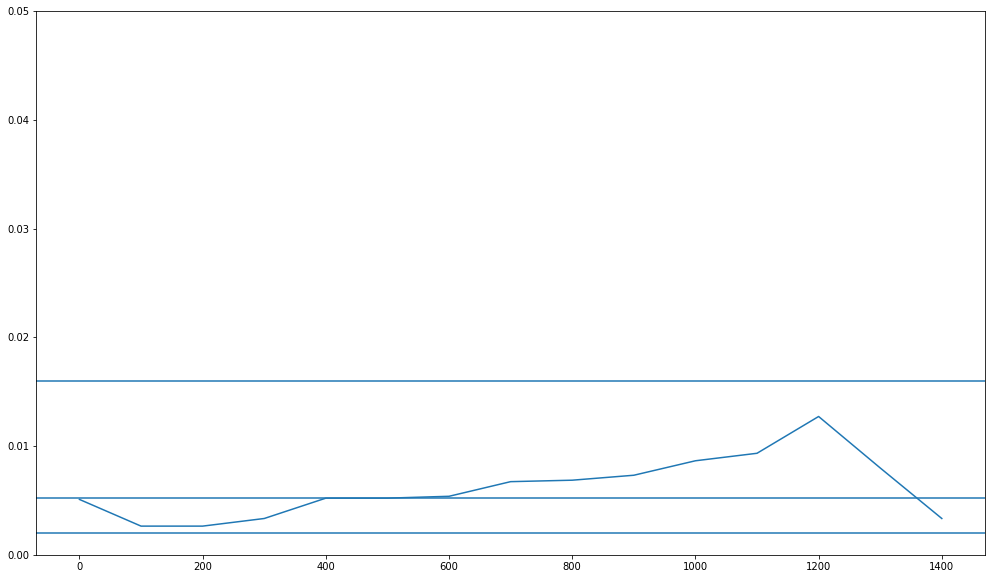

In [25]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.figure(figsize=(17,10))
tst = []
for i in range(0, 1440, 100):
    tst.append(theft_classifier.predict_proba([[34.069216, -118.301586 , i]])[0][1])
plt.plot(range(0, 1440, 100), tst)
plt.ylim([0,.05])
plt.axhline(y=.016, xmin=0, xmax=1440)
plt.axhline(y=.0052, xmin=0, xmax=1440)
plt.axhline(y=.002, xmin=0, xmax=1440)

AttributeError: Unknown property ymin

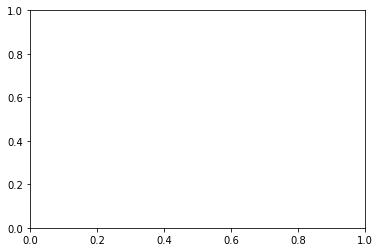

In [60]:
plt.axhline(y=.002, xmin=0, xmax=.05)